# Two-Asset Optimal Portfolios

This note contains formulas for tangency weights for the two-risky asset case.  These formulas are occasionally useful.

Suppose we have two risky assets with expected returns $E[r_1]$ and $E[r_2]$, respectively and standard deviations $\sigma_1$ and $\sigma_2$, respectively.  The correlation of the asset returns is $\rho$.  The risk-free rate is denoted $r_f$.


### GMV 
The global minimum variance portfolio has weight in asset 1 of:

\begin{equation*} 
w^\text{gmv}_1 = \frac{\sigma^2_2 - \rho \sigma_1 \sigma_2}{\sigma^2_1 + \sigma^2_2 - 2 \rho \sigma_1 \sigma_2}\,,
\end{equation*}
and the weight in asset 2 is $1-w^\text{gmv}_1$.


### Optimal portfolio if no risk-free asset
If one has mean-variance preferences with risk aversion $A$ and can only invest in the two risky assets, the optimal portfolio has weight in asset 1 of:
\begin{equation*} 
w_1 = \frac{E[r_1]-E[r_2] + A (\sigma^2_2 - \rho \sigma_1 \sigma_2)}{A(\sigma^2_1 + \sigma^2_2 - 2 \rho \sigma_1 \sigma_2)}\,,
\end{equation*}
and the weight in asset 2 is $1-w_1$.

### Optimal portfolio is risk-free asset available
The tangency portfolio has weight in asset 1 of:

\begin{equation*} 
w^\text{tangency}_1 = \frac{E[r_1-r_f]\sigma^2_2 - E[r_2-r_f]\rho \sigma_1 \sigma_2}{E[r_1-r_f]\sigma^2_2 + E[r_2-r_f]\sigma^2_1  - \big(E[r_1-r_f]+E[r_2-r_f] \big)\rho \sigma_1 \sigma_2}\,,
\end{equation*}
and the weight in asset 2 is $1-w^\text{tangency}_1$.

The optimal portfolio for an investor with mean-variance preferences has the following allocation to the tangency portfolio:
\begin{equation*} 
    w^{\text{CAL}}_{\text{tangency}} = \frac{E[r_{\text{tangency}}]-r_f}{A \sigma^2_{\text{tangency}}}\,,
\end{equation*} 
and the weight in the risk-free asset is $1-w^{\text{CAL}}_{\text{tangency}}$.

In [14]:
# Inputs
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Risk-free rate
r = 0.02
# Expected returns
mns = np.array([0.06, 0.035])
# Standard deviations
sds = np.array([0.15, 0.035])
# Correlations
corr = -0.05

In [31]:
# Define tangency weight (relative to assumed weight) as function of risk-free rate
import scipy.optimize as opt
wgt = 0.6
def tangency_rf(rf):
    m1 = mns[0] - rf
    m2 = mns[1] - rf
    s1 = sds[0]
    s2 = sds[1]
    num = m1*s2**2 - m2*corr*s1*s2
    den = m1*s2**2 + m2*s1**2 - (m1+m2)*corr*s1*s2
    return num/den - wgt

r = opt.root(tangency_rf, x0=0.03, method='hybr')
print(r.message)
print(f'Risk-free rate that makes tangency weight in asset 1 of {wgt: .1%} is a rate of {r.x[0]: .2%}')
    

The solution converged.
Risk-free rate that makes tangency weight in asset 1 of  60.0% is a rate of  3.44%


In [32]:
# Plot the tangency weight in asset 1 as a function of the risk-free rate
rfs = np.arange(0.005, 0.05, 0.0001)
wgt = 0.0
wgts = tangency_rf(rfs)

# Plot
fig = go.Figure()
trace = go.Scatter(
        x=rfs,
        y=wgts,
        mode="lines"
)
fig.add_trace(trace)
fig.layout.xaxis["title"] = "Risk-free"
fig.layout.yaxis["title"] = "Tangency Weight in Asset 1"
fig.update_yaxes(tickformat=".2%")
fig.update_xaxes(tickformat=".2%")
fig.show()

In [33]:
r.x

array([0.03436364])

# Rebalancing notes

In [29]:
from scipy.stats import multivariate_normal as mvn

# Covariance matrix
C  = np.identity(2)
C[0, 1] = C[1, 0] = corr
cov = np.diag(sds) @ C @ np.diag(sds)

T = 5
seed = 6
rets = mvn.rvs(mns, cov, size=T, random_state = seed)

In [59]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

mn_stock = 6 
mn_bond  = 3.5
sd_stock = 15
sd_bond  = 3.5
corr = -5

rf = 3.436364
extra = 0

realized = np.array([
        [ 0.11,  0.06 ],
        [ 0.03,  0.00],
        [ 0.43,  0.06],
        [-0.11, -0.02],
        [-0.20,  0.02]])

In [60]:
df = pd.DataFrame(dtype=float, columns=['beg_wgt1','beg_wgt_bond','ret_stock','ret_bond', 'end_wgt_stock','end_wgt_bond'], index=np.arange(5)+1)
df[['ret_stock','ret_bond']] = realized
df.loc[1,'beg_wgt1'] = 0.60
df.loc[1,'beg_wgt_bond'] = 0.40
for t in df.index:
    if t > 1:
        df.loc[t,'beg_wgt1'] = df.loc[t-1,'end_wgt_stock']
        df.loc[t,'beg_wgt_bond']  = df.loc[t-1,'end_wgt_bond']
    ws = df.loc[t,'beg_wgt_stock']
    wb = df.loc[t,'beg_wgt_bond']
    rs = df.loc[t,'ret_stock']
    rb = df.loc[t,'ret_bond']
    rp = ws*rs + wb*rb
    df.loc[t,'end_wgt_stock'] = ws * (1+rs)/(1+rp)
    df.loc[t,'end_wgt_bond']  = wb * (1+rb)/(1+rp)
df


,beg_wgt_stock,beg_wgt_bond,ret_stock,ret_bond,end_wgt_stock,end_wgt_bond
1,0.600000,0.400000,0.11,0.06,0.611009,0.388991
2,0.611009,0.388991,0.03,0.00,0.618011,0.381989
3,0.618011,0.381989,0.43,0.06,0.685792,0.314208
4,0.685792,0.314208,-0.11,-0.02,0.664673,0.335327
5,0.664673,0.335327,-0.20,0.02,0.608555,0.391445


In [61]:
mn_stock /=100 
mn_bond  /=100 
sd_stock /=100 
sd_bond  /=100 
corr /=100
rf  /=100 

In [69]:
corr

-0.05

In [72]:
df['exp_pret'] = df.beg_wgt1 * mn_stock + df.beg_wgt_bond * mn_bond
df['sd_pret']  = np.sqrt(df.beg_wgt1**2 * (sd_stock)**2  + df.beg_wgt_bond**2 * (sd_bond)**2 + 2*df.beg_wgt1*df.beg_wgt_bond*corr*sd_stock*sd_bond)
df['sharpe ratio'] = (df.exp_pret - rf) / df.sd_pret
df['sharpe ratio']

1    0.172991
2    0.172987
3    0.172981
4    0.172789
5    0.172869
Name: sharpe ratio, dtype: float64

In [79]:
df[['beg_wgt_stock','beg_wgt_bond', 'sharpe ratio']].loc[t].values.tolist()

[0.6646730957278558, 0.3353269042721442, 0.1728691864222712]

In [80]:
def data(mn1, mn2, sd1, sd2, c, rs, extra):
    c = c / 100
    rb = rs + extra   
    rs = rs/100
    rb = rb/100
    mns = [mn1, mn2]
    sds = [sd1, sd2]
    grid = np.linspace(-0.20, 1, 121)
    ports = [np.array([w, 1 - w]) for w in grid]
    means = [p.T @ np.array(mns) for p in ports]
    df = pd.DataFrame(means)
    df.columns = ["mean"]
    cov = np.array(
        [[sds[0] ** 2, sds[0] * sds[1] * c], [sds[0] * sds[1] * c, sds[1] ** 2]]
    ).reshape(2, 2)
    df["stdev"] = [np.sqrt(p.T @ cov @ p) for p in ports]
    df["wt1"] = grid
    df["wt2"] = 1 - df.wt1
    for col in ["mean", "stdev"]:
        df[col] = df[col] / 100
    df["sr_s"]= (df["mean"] - rs)/df["stdev"]
    df["sr_b"]= (df["mean"] - rb)/df["stdev"]
    return df

In [81]:
data(0.1,0.15, 0.1, 0.2, 0.3,0.02, 0.0)

,mean,stdev,wt1,wt2,sr_s,sr_b
0,0.001600,0.002408,-0.20,1.20,0.581463,0.581463
1,0.001595,0.002387,-0.19,1.19,0.584415,0.584415
2,0.001590,0.002366,-0.18,1.18,0.587411,0.587411
3,0.001585,0.002346,-0.17,1.17,0.590453,0.590453
4,0.001580,0.002325,-0.16,1.16,0.593540,0.593540
...,...,...,...,...,...,...
116,0.001020,0.000964,0.96,0.04,0.851005,0.851005
117,0.001015,0.000972,0.97,0.03,0.838448,0.838448
118,0.001010,0.000981,0.98,0.02,0.825742,0.825742
119,0.001005,0.000990,0.99,0.01,0.812916,0.812916


In [ ]:
# Cleaner plot

In [100]:
# Package/inputs
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import multivariate_normal as mvn

mn_stock = 6   /100
mn_bond  = 3.5 /100
sd_stock = 15  /100
sd_bond  = 3.5 /100
corr     = -5  /100
rf       = 3.436364 / 100

# Covariance matrix
C  = np.identity(2)
C[0, 1] = C[1, 0] = corr
cov = np.diag(sds) @ C @ np.diag(sds)

# Periods
T = 10

In [116]:
def portfolio(mn1,mn2, sd1, sd2, c, rf):
    '''
    creates dataset of set of two-asset frontier portfolios
    '''
    mns = [mn1, mn2]
    sds = [sd1, sd2]
    grid = np.linspace(-0.20, 1, 121)
    ports = [np.array([w, 1 - w]) for w in grid]
    means = [p.T @ np.array(mns) for p in ports]
    df = pd.DataFrame(means)
    df.columns = ["mean"]
    cov = np.array([[sds[0] ** 2, sds[0] * sds[1] * c], [sds[0] * sds[1] * c, sds[1] ** 2]]).reshape(2, 2)
    df["stdev"] = [np.sqrt(p.T @ cov @ p) for p in ports]
    df["wt1"] = grid
    df["wt2"] = 1 - df.wt1
    df["sr"]= (df["mean"] - rf)/df["stdev"]
    return df
frontier = portfolio(0.1,0.15, 0.1, 0.2, 0.3,0.02)

,mean,stdev,wt1,wt2,sr
0,0.1600,0.234776,-0.20,1.20,0.596312
1,0.1595,0.233006,-0.19,1.19,0.598697
2,0.1590,0.231238,-0.18,1.18,0.601111
3,0.1585,0.229474,-0.17,1.17,0.603555
4,0.1580,0.227712,-0.16,1.16,0.606028
...,...,...,...,...,...
116,0.1020,0.098695,0.96,0.04,0.830838
117,0.1015,0.098966,0.97,0.03,0.823518
118,0.1010,0.099273,0.98,0.02,0.815929
119,0.1005,0.099618,0.99,0.01,0.808085


In [253]:
# Package/inputs
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import multivariate_normal as mvn

mn_stock = 6   /100
mn_bond  = 3.5 /100
sd_stock = 15  /100
sd_bond  = 3.5 /100
corr     = -5  /100
rf       = 3.436364 / 100

# Covariance matrix
C  = np.identity(2)
C[0, 1] = C[1, 0] = corr
cov = np.diag(sds) @ C @ np.diag(sds)

# Periods
T = 30


# Realizations
def returns(mn1,mn2, sd1, sd2, c, rf, init_wt1, init_wt2, T,seed):
    mns = [mn1, mn2]
    sds = [sd1, sd2]   
    cov = np.array([[sds[0] ** 2, sds[0] * sds[1] * c], [sds[0] * sds[1] * c, sds[1] ** 2]]).reshape(2, 2)

    realized = mvn.rvs(mns, cov, size=T,random_state=seed)
    
    df = pd.DataFrame(dtype=float, columns=['beg_wgt1','beg_wgt2','ret1','ret2', 'end_wgt1','end_wgt2'], index=np.arange(T)+1)
    df[['ret1','ret2']] = realized
    df.loc[1,'beg_wgt1'] = init_wt1
    df.loc[1,'beg_wgt2'] = init_wt2
    for t in df.index:
        if t > 1:
            df.loc[t,'beg_wgt1'] = df.loc[t-1,'end_wgt1']
            df.loc[t,'beg_wgt2'] = df.loc[t-1,'end_wgt2']
        w1 = df.loc[t,'beg_wgt1']
        w2 = df.loc[t,'beg_wgt2']
        r1 = df.loc[t,'ret1']
        r2 = df.loc[t,'ret2']
        rp = w1*r1 + w2*r2
        df.loc[t,'end_wgt1']  = w1 * (1+r1)/(1+rp)
        df.loc[t,'end_wgt2']  = w2 * (1+r2)/(1+rp)
    df['exp_pret'] = df.beg_wgt1 * mns[0] + df.beg_wgt2 * mns[1]
    df['sd_pret']  = np.sqrt(df.beg_wgt1**2 * sds[0]**2  + df.beg_wgt2**2 * sds[1]**2 + 2*df.beg_wgt1*df.beg_wgt2*c*sds[0]*sds[1])        
    df['sharpe ratio'] = (df.exp_pret - rf) / df.sd_pret
    return df

# Tangency portfolio weights
mns = np.array([mn_stock, mn_bond])
sds = np.array([sd_stock, sd_bond])
cov = np.array([[sds[0] ** 2, sds[0] * sds[1] * corr], [sds[0] * sds[1] * corr, sds[1] ** 2]]).reshape(2, 2)
w = np.linalg.solve(cov, mns - rf)
wgts_tangency = w / np.sum(w) 

# Simulate returns
rets = returns(mn_stock,mn_bond,sd_stock, sd_bond, corr, rf, wgts_tangency[0], wgts_tangency[1], T,29)

# Plot Sharpe ratio
fig = go.Figure()  
string = "<br>Year %{x:.0f}<br>"
string += "Stock: %{customdata[0]:.1%}<br>"
string += "Bond: %{customdata[1]:.1%}<br>"
string += "Sharpe ratio: %{customdata[2]:.4f}<br>"
string += "<extra></extra>"
cd = rets[['beg_wgt1','beg_wgt2', 'sharpe ratio']]
trace = go.Scatter(
    x=rets.index,
    y=rets['sharpe ratio'],
    mode="lines",
    customdata=cd,
    hovertemplate=string,
    marker=dict(size=10)
)       
fig.add_trace(trace)
fig.add_hline(y=rets.loc[1,'sharpe ratio'], annotation_text="max Sharpe ratio")
  
fig.layout.xaxis["title"] = "Year"
fig.layout.yaxis["title"] = "Ex Ante Sharpe Ratio"
fig.update_yaxes(tickformat=".4f")
fig.update_layout(legend=dict(yanchor="top", y =0.5, xanchor="left", x=0.65))
fig.show()

In [254]:
rets['ret_rebal'] = wgts_tangency[0]*rets.ret1 + wgts_tangency[1]*rets.ret2
rets['ret_none']  = rets.beg_wgt1*rets.ret1 + rets.beg_wgt2*rets.ret2
for var in ['ret_rebal','ret_none']:
    print((rets[var].mean()-rf)  / rets[var].std())

-0.02774375724436304
-0.09000768206206063


<AxesSubplot:>

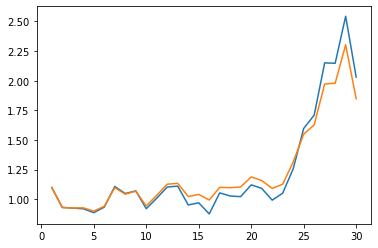

In [256]:
(1+rets.ret_rebal).cumprod().plot()
(1+rets.ret_none).cumprod().plot()

In [182]:
fig = go.Figure()    
for t in rets.index[1:]:
    string = "<br>Stock: %{customdata[0]:.1%}<br>"
    string += "Bond: %{customdata[1]:.1%}<br>"
    string += "Sharpe ratio: %{customdata[2]:.4f}<br>"
    string += "<extra></extra>"
    cd = [rets[['beg_wgt1','beg_wgt2', 'sharpe ratio']].loc[t]]
    trace = go.Scatter(
        x=[rets.loc[t,'sd_pret']],
        y=[rets.loc[t,'exp_pret']],
        mode="markers",
        customdata = cd,
        hovertemplate=string,
        marker=dict(size=10),
        name=f'Year {t:.0f}'
    )       
    fig.add_trace(trace)
fig.layout.xaxis["title"] = "Standard Deviation"
fig.layout.yaxis["title"] = "Expected Return"
fig.update_xaxes(range=[0, 1.05 * frontier["stdev"].max()])
fig.update_yaxes(range=[0, 1.05 * frontier["mean"].max()])
fig.update_yaxes(tickformat=".0%")
fig.update_xaxes(tickformat=".0%")
fig.update_layout(legend=dict(yanchor="top", y =0.5, xanchor="left", x=0.65))
fig.show()

In [123]:
fig = go.Figure()    
trace = go.Scatter(
    x=rets.index,
    y=rets.beg_wgt1,
    mode="lines",
    marker=dict(size=10)
)       
fig.add_trace(trace)
  
fig.layout.xaxis["title"] = "Year"
fig.layout.yaxis["title"] = "Weight in Stock"
# fig.update_xaxes(range=[0, 1.05 * frontier["stdev"].max()])
# fig.update_yaxes(range=[0, 1.05 * frontier["mean"].max()])
fig.update_yaxes(tickformat=".0%")
# fig.update_xaxes(tickformat=".0%")
fig.update_layout(legend=dict(yanchor="top", y =0.5, xanchor="left", x=0.65))
fig.show()

In [181]:
rets

,beg_wgt1,beg_wgt2,ret1,ret2,end_wgt1,end_wgt2,exp_pret,sd_pret,sharpe ratio
1,0.600001,0.399999,0.122926,0.058904,0.614004,0.385996,0.050000,0.090388,0.172991
2,0.614004,0.385996,-0.228320,-0.036311,0.560200,0.439800,0.050350,0.092415,0.172985
3,0.560200,0.439800,-0.047657,0.052655,0.535398,0.464602,0.049005,0.084668,0.172927
4,0.535398,0.464602,-0.054628,0.067246,0.505143,0.494857,0.048385,0.081139,0.172807
5,0.505143,0.494857,-0.061720,0.003392,0.488371,0.511629,0.047629,0.076877,0.172548
6,0.488371,0.511629,0.079084,0.012712,0.504239,0.495761,0.047209,0.074538,0.172337
7,0.504239,0.495761,0.276044,0.055133,0.551579,0.448421,0.047606,0.076750,0.172538
8,0.551579,0.448421,-0.088235,-0.003176,0.529432,0.470568,0.048789,0.083438,0.172893
9,0.529432,0.470568,0.002159,0.050625,0.517651,0.482349,0.048236,0.080294,0.172766
10,0.517651,0.482349,-0.256053,0.031982,0.436191,0.563809,0.047941,0.078633,0.172672


-0.02774375724436304
-0.09000768206206063


In [202]:
numsims = 1000
sharpes = pd.DataFrame(dtype=float,columns=['rebal','none'],index = np.arange(numsims))
for i in sharpes.index:
    rets = returns(mn_stock,mn_bond,sd_stock, sd_bond, corr, rf, wgts_tangency[0], wgts_tangency[1], T,i)
    rets['ret_rebal'] = wgts_tangency[0]*rets.ret1 + wgts_tangency[1]*rets.ret2
    rets['ret_none']  = rets.beg_wgt1*rets.ret1 + rets.beg_wgt2*rets.ret2
    for var in ['rebal','none']:
        sharpes.loc[i,var] = (rets['ret_'+var].mean()-rf)  / rets['ret_'+var].std()

0.874

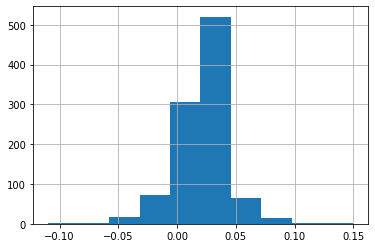

In [210]:
# sharpes.hist()
sharpes.describe()
(sharpes.rebal-sharpes.none).hist()
((sharpes.rebal-sharpes.none) >0).mean()

In [248]:
fig = go.Figure()
frac_pos = ((sharpes.rebal-sharpes.none) >0).mean()
trace = go.Histogram(x=sharpes.rebal-sharpes.none, histnorm='percent',hovertemplate="<br>%{y}% of simulations<br><extra></extra>")
fig.add_trace(trace)
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.layout.xaxis["title"] = "Difference in Realized Sharpe Ratios:<br> Rebalanced - Non-Rebalanced"
fig.layout.yaxis["title"] = "Percent of Simulations"
fig.add_annotation(x=(sharpes.rebal-sharpes.none).max()*0.8, y=13,
            text="Rebalanced outperforms non-rebalanced in <br>"+f'{frac_pos:.1%} of simulations', showarrow=False)
fig.show()

In [252]:
sharpes.loc[29]
-0.0277--0.0900008


0.0623008

In [263]:
import numpy as np
from scipy.optimize import minimize

##### Inputs
# Risk-free rate
r = 0.02
# Expected returns
mns = np.array([0.10, 0.05, 0.07])
# Standard deviations
sds = np.array([0.20, 0.12, 0.15])
# Correlations
corr12 = 0.3
corr13 = 0.3
corr23 = 0.3
# Covariance matrix
C  = np.identity(3)
C[0, 1] = C[1, 0] = corr12
C[0, 2] = C[2, 0] = corr13
C[1, 2] = C[2, 1] = corr23
cov = np.diag(sds) @ C @ np.diag(sds)

##### Tangency Portfolio
w = np.linalg.solve(cov, mns - r)
wgts_tangency = w / np.sum(w)
mnTang = mns @ wgts_tangency
sdTang = np.sqrt(wgts_tangency @ cov @ wgts_tangency)
srTang = (mnTang - r)/sdTang

##### Frontier Portfolios
def frontier(means, cov, target):
    n = len(means)
    w = np.linalg.solve(cov, np.ones(n))
    wgts_gmv = w / np.sum(w)
    w = np.linalg.solve(cov, means)
    piMu = w / np.sum(w)
    m1 = wgts_gmv @ means
    m2 = piMu @ means
    a = (target - m2) / (m1 - m2)
    wgts = a * wgts_gmv + (1 - a) * piMu
    return wgts
wgts_frontier = [frontier(mns, cov, m) for m in np.linspace(mns.min(), mns.max(),40)]
mn_frontier = [mns @ w for w in wgts_frontier]
sd_frontier = [np.sqrt(w @ cov @ w) for w in wgts_frontier]


In [269]:
wgts_tangency

array([0.41180371, 0.20888594, 0.37931034])

In [289]:
##### Plot portfolios in expected return-stdev space
fig = go.Figure()  

# Plot assets
for i in np.arange(len(mns)):
    trace = go.Scatter(x=[sds[i]], y=[mns[i]], mode="markers", hovertemplate="Asset "+str(i+1),marker=dict(size=10, color="red"), name="Asset "+str(i+1)) 
    fig.add_trace(trace)

# Plot frontier
string = "<br>"
string += "Asset 1: %{customdata[0]:.1%}<br>"
string += "Asset 2: %{customdata[1]:.1%}<br>"
string += "Asset 3: %{customdata[2]:.1%}<br>"
string += "<extra></extra>"
trace0 = go.Scatter(x=sd_frontier, y=mn_frontier, mode="lines", customdata=wgts_frontier, hovertemplate=string, marker=dict(size=10, color="blue"), name="Frontier")       
fig.add_trace(trace0)

# Plot tangency
string = "<br>Tangency Portfolio:<br>"
string += "Asset 1: %{customdata[0]:.1%}<br>"
string += "Asset 2: %{customdata[1]:.1%}<br>"
string += "Asset 3: %{customdata[2]:.1%}<br>"
string += "<extra></extra>"
trace1 = go.Scatter(x=[sdTang], y=[mnTang], mode="markers", customdata=[wgts_tangency], hovertemplate=string, marker=dict(size=10, color="blue"), name="Tangency")   
fig.add_trace(trace1)

fig.layout.xaxis["title"] = "Standard Deviation"
fig.layout.yaxis["title"] = "Expected Return"
fig.update_xaxes(range=[0, 1.05 * sds.max()])
fig.update_yaxes(range=[0, 1.05 * mns.max()])
fig.update_yaxes(tickformat=".0%")
fig.update_xaxes(tickformat=".0%")
fig.update_layout(legend=dict(yanchor="top", y =0.95, xanchor="left", x=0.05))
fig.show()